# Initializatoin

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# cd /content/drive/MyDrive/Colab\ Notebooks/Deep\ Learning\ Course/HW03

In [1]:
!cp /kaggle/input/name-dataset/name_dataset.py ./

## Imports

In [2]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch.nn import Parameter

from name_dataset import Dataset

# RNN

## Traditional RNN

In the introductory section, we delve into the architecture of Recurrent Neural Networks (RNNs) and elucidate their training methodologies. To gain a deeper understanding of RNNs, you're encouraged to explore further [HERE](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-network)

For the task at hand, you've been furnished with the Names dataset, a compilation comprising thousands of surnames from 18 distinct languages of origin. Your objective is to prognosticate the language of origin for a given name, relying solely on its orthography. Your task primarily involves implementing the section demarcated by `#your_code`.

In [3]:
dataset = Dataset()
for i in range(10):
    category, line, _, _ = dataset.randomTrainingExample()
    print("category =", category, "- random name =", line)

Error occurred while downloading data.zip: --2024-04-26 19:23:50--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.165.116.45, 18.165.116.18, 18.165.116.36, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.165.116.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: 'data.zip'

     0K .......... .......... .......... .......... ..........  1% 1.73M 2s
    50K .......... .......... .......... .......... ..........  3% 2.44M 1s
   100K .......... .......... .......... .......... ..........  5% 9.43M 1s
   150K .......... .......... .......... .......... ..........  7% 9.40M 1s
   200K .......... .......... .......... .......... ..........  8% 9.90M 1s
   250K .......... .......... .......... .......... .......... 10% 13.4M 1s
   300K .......... .......... .......... .......... .......... 12% 27.9M 0s
   350K .......... .......... .......... ....

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        # your_code
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, input, hidden):
        # your_code
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


n_hidden = 128
n_letters = dataset.n_letters
n_categories = dataset.n_categories
rnn = RNN(n_letters, n_hidden, n_categories)

In [5]:
# your_code
criterion = nn.NLLLoss()
learning_rate = 0.005


def train(category_tensor, name_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    # your_code
    for i in name_tensor:
        output, hidden = rnn(i, hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

And here you can train your model and see it's performance after each 5000 iterations

5000 5% 3.0400 Pape is predicted as a "Chinese" name, status = ✗ (French)
10000 10% 1.0773 Gu is predicted as a "Korean" name, status = ✓
15000 15% 0.6806 Kuga is predicted as a "Japanese" name, status = ✓
20000 20% 1.7757 Fawcett is predicted as a "Dutch" name, status = ✗ (English)
25000 25% 0.1876 Koutsoubos is predicted as a "Greek" name, status = ✓
30000 30% 0.6248 Xie is predicted as a "Chinese" name, status = ✓
35000 35% 0.6014 Aggi is predicted as a "Italian" name, status = ✓
40000 40% 0.0557 Antoniadis is predicted as a "Greek" name, status = ✓
45000 45% 0.3832 Coupe is predicted as a "French" name, status = ✓
50000 50% 0.0979 Stawski is predicted as a "Polish" name, status = ✓
55000 55% 3.3466 Ferro is predicted as a "Portuguese" name, status = ✗ (Italian)
60000 60% 0.0034 Kotsiopoulos is predicted as a "Greek" name, status = ✓
65000 65% 1.5057 Downer is predicted as a "Czech" name, status = ✗ (English)
70000 70% 0.7849 Werlla is predicted as a "Czech" name, status = ✓
75000 7

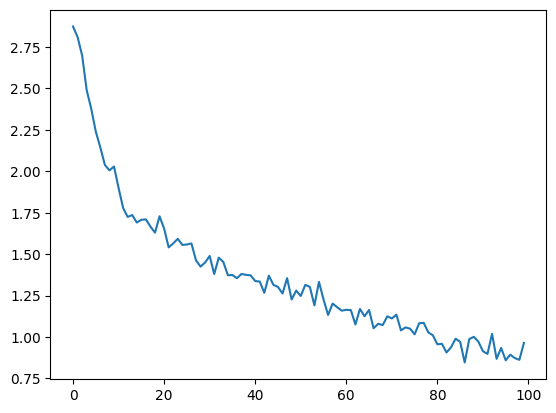

In [6]:
n_iters = 100000
print_every = 5000

current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = dataset.randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, _ = dataset.categoryFromOutput(output)
        correct = "✓" if guess == category else "✗ (%s)" % category
        print(
            '%d %d%% %.4f %s is predicted as a "%s" name, status = %s'
            % (iter, iter / n_iters * 100, loss, line, guess, correct)
        )

    if iter % 1000 == 0:
        all_losses.append(current_loss / 1000)
        current_loss = 0

plt.figure()
plt.plot(all_losses)

## Traditional RNN Disadvantages

In this part, we aim to delve into the limitations of traditional RNNs:
1.   Recurrent computation is slow
2.   They have difficulty accessing information from many steps back.

You are provided with a simple code that helps you to give the idea better. By modifying this code, you are able to demonstrate the mentioned disadvantages, but you are also free to change the code if needed or use any dataset you want.

**Question:** Do you think using GPU instead of CPU completely solves the first problem?

**Answer:** No it won't completely solve the problem of slow computation because the algorithm is sequential in its nature and it can't get parallelized. So even if we use a GPU, we can't leverage its parallelization powers for a sequential task.

Note: The main goal of this part is to help you understand these problems better. Don't be too hard to implement and delivery.

Epoch [10/100], Loss: 1.3465
Epoch [20/100], Loss: 1.2627
Epoch [30/100], Loss: 1.1923
Epoch [40/100], Loss: 1.1276
Epoch [50/100], Loss: 1.0651
Epoch [60/100], Loss: 1.0027
Epoch [70/100], Loss: 0.9371
Epoch [80/100], Loss: 0.8642
Epoch [90/100], Loss: 0.7787
Epoch [100/100], Loss: 0.6755


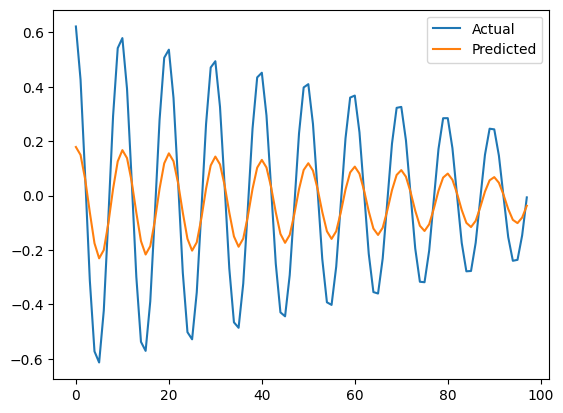

In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Generate sinusoidal temperature data with decreasing range over time
np.random.seed(0)
num_periods = 50
timesteps_per_period = 10
total_timesteps = num_periods * timesteps_per_period

# Generate decreasing factor
decreasing_factor = np.linspace(1, 0.1, total_timesteps)

# Generate temperature data with decreasing sinusoidal range
temperature_data = (
    np.sin(np.linspace(0, 2 * np.pi * num_periods, total_timesteps)) * decreasing_factor
)

# Normalize the data
temperature_data = (temperature_data - np.mean(temperature_data)) / np.std(
    temperature_data
)

# Convert numpy array to PyTorch tensor
temperature_data = torch.tensor(temperature_data, dtype=torch.float32).view(-1, 1)


# Define function to create dataset with sinusoidal pattern
def create_dataset(data, seq_length):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        seq_in = data[i : i + seq_length]
        seq_out = data[i + seq_length]
        X.append(seq_in)
        Y.append(seq_out)
    return torch.stack(X), torch.stack(Y)


# Define sequence length and create dataset
sequence_length = 10  # Number of previous days to look at for prediction
X, Y = create_dataset(temperature_data, sequence_length)

# Split the dataset into train and test sets
train_size = int(0.8 * len(X))
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]


# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


# Define model parameters
input_size = 1
hidden_size = 10
output_size = 1

# Instantiate the model
model = SimpleRNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)

# Plot actual vs predicted
plt.plot(Y_test.numpy(), label="Actual")
plt.plot(test_predictions.numpy(), label="Predicted")
plt.legend()
plt.show()

# LSTM Preparation

Now that you have experience with traditional RNNs, it's time to implement the LSTM model. Your goal is to implement the cell and model for LSTM architecture. The proposed dataset for this section is MNIST, allowing you to focus solely on model implementation.

In [12]:
train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transforms.ToTensor(), download=True
)

test_dataset = datasets.MNIST(
    root="./data", train=False, transform=transforms.ToTensor()
)

batch_size = 128
n_iters = 6000
num_epochs = int(n_iters / (len(train_dataset) / batch_size))

In [13]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)

## LSTM Cells

In [14]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.xh = nn.Linear(input_size, hidden_size * 4, bias=bias)
        self.hh = nn.Linear(hidden_size, hidden_size * 4, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):

        # Inputs:
        #       input: (batch_size, input_size)
        #       hx: (batch_size, hidden_size)
        # Outputs:
        #       hy: (batch_size, hidden_size)
        #       cy: (batch_size, hidden_size)

        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))
            hx = (hx, hx)

        hx, cx = hx

        # your code
        gates = self.xh(input) + self.hh(hx)
        input_gate, forget_gate, cell_gate, output_gate = gates.squeeze().chunk(4, 1)

        i_t = F.sigmoid(input_gate)
        f_t = F.sigmoid(forget_gate)
        g_t = F.tanh(cell_gate)
        o_t = F.sigmoid(output_gate)

        cy = f_t * cx + i_t * g_t
        hy = o_t * F.tanh(cy)

        return (hy, cy)

## LSTM Models

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        # Initialize hidden state with zeros
        c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        h0 = h0.to(device)
        c0 = c0.to(device)

        cn = c0[0, :, :]
        hn = h0[0, :, :]
        outs = []

        for seq in range(x.size(1)):
            # your code
            hn, cn = self.lstm(x[:, seq, :], (hn, cn))
            outs.append(hn)

        # your code
        out = self.fc(outs[-1])
        return out

In [17]:
input_dim = 28
hidden_dim = 128
layer_dim = 1  # ONLY 1 OR 2
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

# your code
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [18]:
# your code
# Train model and print Loss and Accuracy on Test Dataset after each 500 iterations


def train_network(
    model,
    criterion,
    train_loader,
    sequence_length=28,
    input_dim=28,
    test_loader=None,
    epochs=50,
    device="cpu",
    optimizer=None,
    log_interval=None,
):
    iter_count = 0
    results = {
        "train_loss": [],
        "test_loss": [],
    }

    model.to(device)
    for _ in range(epochs):
        for inputs, labels in train_loader:
            model.train()
            inputs = inputs.to(device)
            labels = labels.to(device)

            inputs = inputs.reshape(-1, sequence_length, input_dim)

            y_hat = model(inputs)
            loss = criterion(y_hat, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            results["train_loss"].append(loss.item())

            iter_count += 1
            if iter_count % log_interval == 0:
                model.eval()
                with torch.no_grad():
                    n_correct = 0
                    for inputs, labels in test_loader:
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        inputs = inputs.reshape(-1, sequence_length, input_dim)

                        y_hat = model(inputs)
                        loss = criterion(y_hat, labels)
                        results["test_loss"].append(loss.item())

                        y_pred = torch.argmax(y_hat, dim=1)
                        n_correct += torch.sum(y_pred == labels).item()
                    test_acc = n_correct / len(test_loader.dataset)
                    print(
                        f"[iteration {iter_count:4}]:  test loss = {loss:.4f}, test acc = {test_acc:.4f}"
                    )

    return results

In [19]:
results = train_network(
    model,
    criterion,
    train_loader,
    test_loader=test_loader,
    sequence_length=28,
    input_dim=input_dim,
    optimizer=optimizer,
    epochs=num_epochs,
    device=device,
    log_interval=500,
)

[iteration  500]:  test loss = 0.0625, test acc = 0.9358
[iteration 1000]:  test loss = 0.0267, test acc = 0.9581
[iteration 1500]:  test loss = 0.0148, test acc = 0.9674
[iteration 2000]:  test loss = 0.0107, test acc = 0.9743
[iteration 2500]:  test loss = 0.0622, test acc = 0.9722
[iteration 3000]:  test loss = 0.0056, test acc = 0.9749
[iteration 3500]:  test loss = 0.0023, test acc = 0.9809
[iteration 4000]:  test loss = 0.0027, test acc = 0.9817
[iteration 4500]:  test loss = 0.0010, test acc = 0.9801
[iteration 5000]:  test loss = 0.0013, test acc = 0.9844
[iteration 5500]:  test loss = 0.0014, test acc = 0.9830


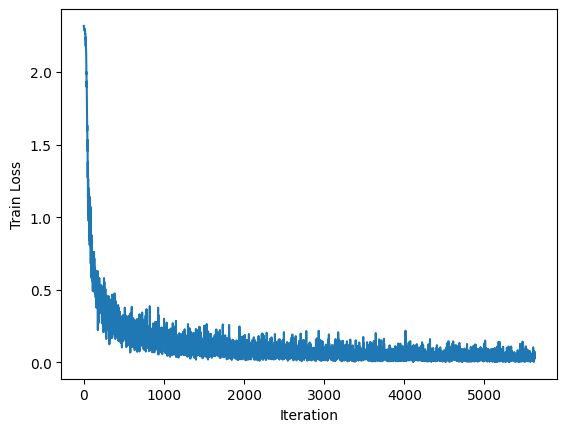

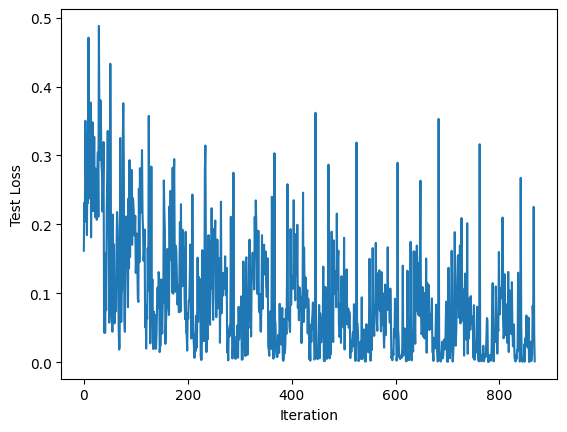

In [20]:
plt.plot(results["train_loss"])
plt.xlabel("Iteration")
plt.ylabel("Train Loss")
plt.show()

plt.plot(results["test_loss"])
plt.xlabel("Iteration")
plt.ylabel("Test Loss")
plt.show()

# Sentiment Analysis

Now you are ready to face a real-world problem. In this task, we want you to do a sentiment analysis on the [IMDB dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). The main goal is to reach more than an acceptable accuracy of **75%** on LSTM model. You are free to use torch.nn.LSTM to design your architecture, but you must prepare the IMDB dataset on your own.

In [21]:
import time
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))

from torch.utils.data import TensorDataset, DataLoader

from tqdm.notebook import tqdm
from collections import Counter

# WordNet
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/

## Dataset

In [22]:
class IMDBDataset:
    def __init__(self, dataset_path):
        self.raw_df = pd.read_csv(dataset_path)

    def do_preprocessing(self):
        self.raw_df["sentiment"] = (self.raw_df["sentiment"] == "positive").astype(int)
        self.raw_df = self.__clean_text(self.raw_df, "review")
        self.raw_df["review"] = self.raw_df["review"].apply(self.__preprocess_text)

        return self.raw_df

    def __preprocess_text(self, text):
        tokens = word_tokenize(text)
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
        tokens = [t for t in tokens if t not in stopwords]

        return " ".join(tokens)

    def __clean_text(self, df, col_name):
        df[col_name] = df[col_name].apply(self.__remove_links)
        df[col_name] = df[col_name].apply(self.__remove_tags)
        df[col_name] = df[col_name].apply(self.__remove_extra_whitespace)
        df[col_name] = df[col_name].apply(self.__remove_numbers)
        df[col_name] = df[col_name].apply(self.__remove_punctuations)

        return df

    def __remove_punctuations(self, text):
        return re.sub(r"[^\w\s]", "", text)

    def __remove_links(self, text):
        return re.sub(r"http\S+|www\S+", "", text)

    def __remove_tags(self, text):
        return re.sub(r"<[^>]+>", "", text)

    def __remove_extra_whitespace(self, text):
        return re.sub(r"\s+", " ", text).strip()

    def __remove_numbers(self, text):
        return re.sub(r"\d+", "", text)

In [23]:
imdb_dataset = IMDBDataset(
    dataset_path="/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv"
)
preprocessed_df = imdb_dataset.do_preprocessing()
preprocessed_df.head()

,review,sentiment
0,One reviewer ha mentioned watching Oz episode ...,1
1,A wonderful little production The filming tech...,1
2,I thought wa wonderful way spend time hot summ...,1
3,Basically family little boy Jake think zombie ...,0
4,Petter Matteis Love Time Money visually stunni...,1


In [24]:
def make_dictionary(preprocessed_df):
    all_words = " ".join(preprocessed_df.review.values).split()
    counter = Counter(all_words)
    vocab = sorted(counter, key=counter.get, reverse=True)

    idx_to_token = dict(enumerate(vocab, 1))
    idx_to_token[0] = "<PADDING>"
    token_to_idx = {token: idx for idx, token in idx_to_token.items()}

    return idx_to_token, token_to_idx


def pad_sequence(sequence, seq_length):
    if len(sequence) >= seq_length:
        return sequence[:seq_length]
    else:
        padded_sequence = sequence + [0] * (seq_length - len(sequence))
        return padded_sequence

In [25]:
idx_to_token, token_to_idx = make_dictionary(preprocessed_df)
preprocessed_df["tokens"] = preprocessed_df["review"].apply(
    lambda x: [token_to_idx[token] for token in x.split()]
)

seq_length = 256
preprocessed_df["tokens"] = preprocessed_df["tokens"].apply(
    lambda x: pad_sequence(x, seq_length)
)

preprocessed_df.head()

,review,sentiment,tokens
0,One reviewer ha mentioned watching Oz episode ...,1,"[227, 1054, 8, 943, 81, 3772, 184, 439, 2971, ..."
1,A wonderful little production The filming tech...,1,"[60, 318, 55, 246, 5, 1242, 1613, 17848, 89094..."
2,I thought wa wonderful way spend time hot summ...,1,"[1, 101, 3, 318, 27, 1009, 9, 896, 1753, 2510,..."
3,Basically family little boy Jake think zombie ...,0,"[2724, 141, 55, 249, 3460, 34, 677, 4406, 593,..."
4,Petter Matteis Love Time Money visually stunni...,1,"[89098, 35004, 1123, 1977, 7469, 2188, 1279, 4..."


In [26]:
y = np.array(preprocessed_df["sentiment"].tolist())
X = np.array(preprocessed_df["tokens"].tolist())

train_frac, val_frac, test_frac = 0.7, 0.1, 0.2
train_size = int(train_frac * len(X))
val_size = int(val_frac * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = (
    X[train_size : train_size + val_size],
    y[train_size : train_size + val_size],
)
X_test, y_test = X[train_size + val_size :], y[train_size + val_size :]

print("train split: ", X_train.shape, y_train.shape)
print("val split: ", X_val.shape, y_val.shape)
print("test split: ", X_test.shape, y_test.shape)

train split:  (35000, 256) (35000,)
val split:  (5000, 256) (5000,)
test split:  (10000, 256) (10000,)


## Model

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [28]:
num_epochs = 10
batch_size = 256
lr = 1e-3

vocab_size = len(idx_to_token)
embedding_size = 256
hidden_size = 512
n_layers = 2

In [29]:
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [30]:
class LSTMModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        output_size=1,
        hidden_size=128,
        embedding_size=256,
        n_layers=2,
    ):
        super(LSTMModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.embedding(x.long())
        out, _ = self.lstm(out)
        out = out[:, -1, :]
        out = self.fc(out)

        return out

In [31]:
# works for both train and test
def run_epoch(
    model,
    optimizer,
    data_loader,
    criterion,
    device,
    results,
    score_funcs=None,
    prefix="",
    desc=None,
):
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.unsqueeze(1).float()

        y_hat = model(inputs)
        loss = criterion(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Store metrics
        running_loss.append(loss.item())
        if score_funcs is None:
            score_funcs = {}
        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            # moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            # add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())

    end = time.time()

    y_pred = np.asarray(y_pred)
    y_pred = np.array([1 if i == True else 0 for i in y_pred > 0.5])

    results[prefix + " loss"].append(np.mean(running_loss))
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append(score_func(y_true, y_pred))
        except:
            results[prefix + " " + name].append(float("NaN"))

    return end - start

In [32]:
def train_network(
    model,
    criterion,
    train_loader,
    val_loader=None,
    test_loader=None,
    score_funcs=None,
    epochs=50,
    device="cpu",
    checkpoint_file=None,
    lr_scheduler=None,
    optimizer=None,
    disable_tqdm=False,
    log_items=(),
):
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    if test_loader is not None:
        to_track.append("test loss")
    if score_funcs is not None:
        for eval_score in score_funcs:
            to_track.append("train " + eval_score)
            if val_loader is not None:
                to_track.append("val " + eval_score)
            if test_loader is not None:
                to_track.append("test " + eval_score)

    # Initialization
    total_train_time = 0
    results = {}
    for item in to_track:
        results[item] = []

    if optimizer == None:
        optimizer = torch.optim.AdamW(model.parameters())

    model.to(device)
    pbar = tqdm(range(epochs), desc="Epoch", disable=disable_tqdm)
    for epoch in pbar:
        model = model.train()

        total_train_time += run_epoch(
            model=model,
            optimizer=optimizer,
            data_loader=train_loader,
            criterion=criterion,
            device=device,
            results=results,
            score_funcs=score_funcs,
            prefix="train",
            desc="Training",
        )

        results["epoch"].append(epoch)
        results["total time"].append(total_train_time)

        # Predict the validation set
        if val_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(
                    model=model,
                    optimizer=optimizer,
                    data_loader=val_loader,
                    criterion=criterion,
                    device=device,
                    results=results,
                    score_funcs=score_funcs,
                    prefix="val",
                    desc="Validating",
                )

        if lr_scheduler is not None:
            if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_scheduler.step(results["val loss"][-1])
            else:
                lr_scheduler.step()

        # Predict the validation set
        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(
                    model=model,
                    optimizer=optimizer,
                    data_loader=test_loader,
                    criterion=criterion,
                    device=device,
                    results=results,
                    score_funcs=score_funcs,
                    prefix="test",
                    desc="Testing",
                )

        log_postfix = {}
        log_str = f"Epoch [{epoch+1}]: "
        for log_item in log_items:
            log_postfix[log_item] = results[log_item][-1]
            log_str += f"{log_item}: {results[log_item][-1]:.4f}, "

        pbar.set_postfix(log_postfix)
        print(log_str)

    if checkpoint_file is not None:
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "results": results,
            },
            checkpoint_file,
        )

    return results

In [33]:
def test_network(
    model,
    optimizer,
    criterion,
    test_loader,
    score_funcs=None,
    device="cpu",
):
    to_track = ["total time", "test loss"]
    for eval_score in score_funcs:
        to_track.append("test " + eval_score)

    # Initialization
    total_test_time = 0
    results = {}
    for item in to_track:
        results[item] = []

    model.to(device)
    model = model.eval()
    with torch.no_grad():
        total_test_time += run_epoch(
            model=model,
            optimizer=optimizer,
            data_loader=test_loader,
            criterion=criterion,
            device=device,
            results=results,
            score_funcs=score_funcs,
            prefix="test",
            desc="Testing",
        )
        results["total time"].append(total_test_time)
        
    return results

In [34]:
model = LSTMModel(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    embedding_size=embedding_size,
    n_layers=n_layers,
)

# RNN based models are sensetive to gradient explode/vanishing
# so we add gradient clipping
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -5, 5))

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
score_funcs = {"acc": accuracy_score}

train_results = train_network(
    model=model,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    score_funcs=score_funcs,
    epochs=num_epochs,
    device=device,
    log_items=("train loss", "val loss", "train acc", "val acc"),
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/137 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1]: train loss: 0.6946, val loss: 0.6921, train acc: 0.5000, val acc: 0.4994, 


Training:   0%|          | 0/137 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2]: train loss: 0.6933, val loss: 0.6929, train acc: 0.5017, val acc: 0.4994, 


Training:   0%|          | 0/137 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3]: train loss: 0.6896, val loss: 0.6940, train acc: 0.5106, val acc: 0.4994, 


Training:   0%|          | 0/137 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4]: train loss: 0.6798, val loss: 0.6924, train acc: 0.5261, val acc: 0.5070, 


Training:   0%|          | 0/137 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5]: train loss: 0.6494, val loss: 0.6906, train acc: 0.5431, val acc: 0.5148, 


Training:   0%|          | 0/137 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6]: train loss: 0.5625, val loss: 0.5000, train acc: 0.6716, val acc: 0.7786, 


Training:   0%|          | 0/137 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7]: train loss: 0.4374, val loss: 0.4671, train acc: 0.8029, val acc: 0.7952, 


Training:   0%|          | 0/137 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8]: train loss: 0.3258, val loss: 0.4143, train acc: 0.8667, val acc: 0.8302, 


Training:   0%|          | 0/137 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9]: train loss: 0.2183, val loss: 0.4194, train acc: 0.9159, val acc: 0.8430, 


Training:   0%|          | 0/137 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10]: train loss: 0.1536, val loss: 0.4132, train acc: 0.9453, val acc: 0.8442, 


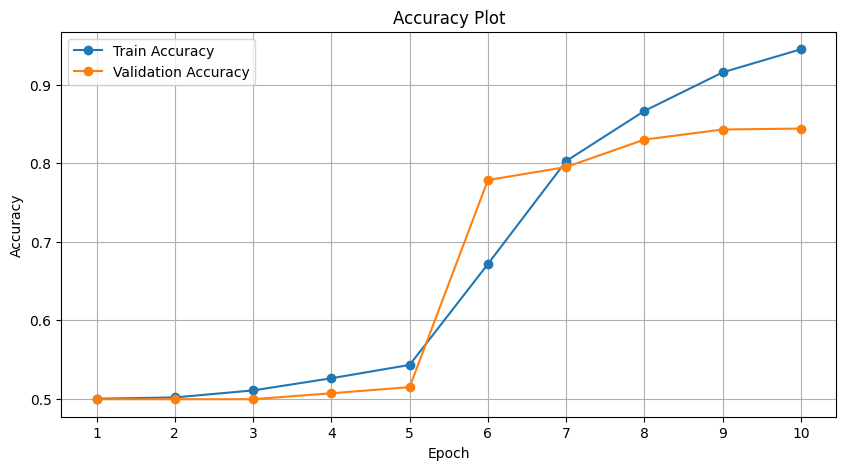

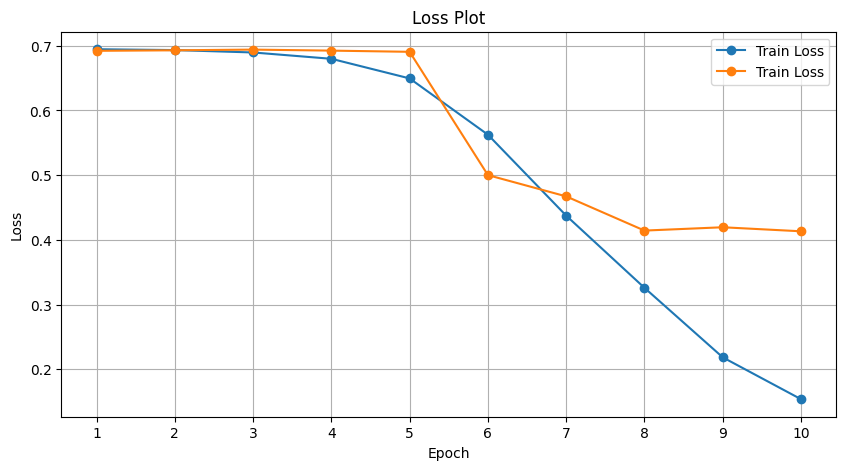

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(
    range(1, num_epochs + 1),
    train_results["train acc"],
    label="Train Accuracy",
    marker="o",
)
plt.plot(
    range(1, num_epochs + 1),
    train_results["val acc"],
    label="Validation Accuracy",
    marker="o",
)
plt.title("Accuracy Plot")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(
    range(1, num_epochs + 1),
    train_results["train loss"],
    label="Train Loss",
    marker="o",
)
plt.plot(
    range(1, num_epochs + 1), train_results["val loss"], label="Train Loss", marker="o"
)
plt.title("Loss Plot")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.grid(True)
plt.show()

In [36]:
test_results = test_network(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    test_loader=test_loader,
    score_funcs=score_funcs,
    device=device,
)

print(
    f"test loss= {test_results['test loss'][-1]:.4f}, test accuracy= {test_results['test acc'][-1]:.4f}"
)

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

test loss= 0.4766, test accuracy= 0.8278
